In [1]:
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from torch.optim import AdamW
import numpy as np
import random
from collections import deque
from torch.utils.data import IterableDataset
from torch.utils.data import DataLoader
import warnings

import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
from gymnasium.spaces import Discrete, Box
from gymnasium.wrappers import NormalizeObservation, NormalizeReward

In [3]:
class Data(IterableDataset):
    def __init__(self, env, policy, steps, gamma):
        self.env = env
        self.policy = policy
        self.steps = steps
        self.gamma = gamma
        self.obs, self.info = env.reset()


    def __iter__(self):
        transitions = []

        for step in range(self.steps):
            with torch.no_grad():
                action = self.policy(torch.as_tensor(self.obs, dtype=torch.float32))
            action = action.multinomial(1).cpu().numpy()
            next_obs, reward, terminated, truncated , info = self.env.step(action.flatten())
            transitions.append((self.obs, action, reward, terminated))
            self.obs = next_obs

        obs_b, action_b, reward_b, done_b = map(np.stack, zip(*transitions))

        running_return = np.zeros(self.env.num_envs, dtype=np.float32)
        return_b = np.zeros_like(reward_b)

        for row in range(self.steps-1,-1,-1):
            running_return = reward_b[row] + (1-done_b[row]) * self.gamma * running_return
            return_b[row] = running_return

        num_samples = self.env.num_envs * self.steps
        obs_b = obs_b.reshape(num_samples, -1)
        action_b = action_b.reshape(num_samples, -1)
        return_b = return_b.reshape(num_samples, -1)

        return_b = (return_b - np.mean(return_b)) / np.std(return_b + 1e-06)

        idx = list(range(num_samples))
        random.shuffle(idx)

        for i in idx:
            yield obs_b[i], action_b[i], return_b[i]

In [4]:
class PolicyNet(nn.Module):
    def __init__(self, input_size, hidden_units=64, output_size=2):
        super(PolicyNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_size),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, x):
        probs = self.model(x)
        return probs

    def __call__(self, x):
        out = self.forward(x)
        return out

In [5]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight.data, 1)
      nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

In [8]:
env = gym.vector.make('LunarLander-v2', num_envs=5, asynchronous=False)

obs_dim = env.single_observation_space.shape[0]
n_acts = env.single_action_space.n

# make core of policy network
hidden_sizes = 32
logits_net = PolicyNet(obs_dim, hidden_sizes, n_acts)
logits_net.apply(initialize_weights)
# make optimizer
optimizer = AdamW(logits_net.parameters(), lr=0.0003)
gamma = 0.99

In [9]:
# make function to compute action distribution
def get_policy(obs):
    probs = logits_net(obs)
    return Categorical(probs=probs)


# make action selection function (outputs int actions, sampled from policy)
def get_action(obs):
    return get_policy(obs).sample().item()


# make loss function whose gradient, for the right data, is policy gradient
def compute_loss(obs, act, weights):
    probs = logits_net(obs)
    log_probs = torch.log(probs + 1e-6)
    action_log_prob = log_probs.gather(1, act)
    return -(action_log_prob * weights).mean()

In [10]:
data = Data(env, logits_net, 128, 0.99)
loader = DataLoader(data, batch_size=24)

def train_one_epoch():
    # make some empty lists for logging.
    batch_obs = []          # for observations
    batch_acts = []         # for actions
    batch_weights = []      # for R(tau) weighting in policy gradient

    # collect experience by acting in the environment with current policy
    
    for batch in loader:
        with torch.no_grad():
            batch_obs, batch_acts, batch_weights = batch

        # take a single policy gradient update step
        optimizer.zero_grad()
        batch_loss = compute_loss(obs=batch_obs, act=batch_acts, weights=batch_weights)
        batch_loss.backward()
        optimizer.step()
    return 0

In [11]:
def run_test(trajectories, policy):
    env2 = gym.make('LunarLander-v2')
    scores = []
    for trajectory in range(trajectories):
        trajectory_return = 0
        obs, info = env2.reset()
        terminated = False
        truncated = False
        while not terminated and not truncated:
            action = get_action(torch.as_tensor(obs, dtype=torch.float32))
            next_obs, reward, terminated, truncated, _ = env2.step(action)
            obs = next_obs            
            trajectory_return += reward
        scores.append(trajectory_return)
    del env2
    return np.mean(scores)

In [12]:
scores = deque(maxlen=50)
graph_results = []

for epoch in range(1000):
    train_one_epoch()
    score = run_test(5, logits_net)
    scores.append(score)
    graph_results.append(score)

    if epoch>1 and epoch % 50 == 0:
        print(f'Epoch: {epoch}  Score: {np.mean(scores)}' )

    if np.mean(scores) >= 195:
        print(f'Solved! Epoch: {epoch}  Score: {np.mean(scores)}')
        break

Epoch: 50  Score: -249.3447709883457
Epoch: 100  Score: -126.38090866286764
Epoch: 150  Score: -97.47196979470036
Epoch: 200  Score: -86.12487559916019
Epoch: 250  Score: -76.02195904041153
Epoch: 300  Score: -48.57492429852917
Epoch: 350  Score: -29.718564708436134
Epoch: 400  Score: -22.808166034863852
Epoch: 450  Score: -1.7326199725201503
Epoch: 500  Score: 53.616117742952426
Epoch: 550  Score: 69.67769503611424
Epoch: 600  Score: 91.15599089193587
Epoch: 650  Score: 125.63974301962253
Epoch: 700  Score: 158.40737304193502
Epoch: 750  Score: 151.10835139527626
Epoch: 800  Score: 159.8271761141791
Epoch: 850  Score: 177.31939389029517
Epoch: 900  Score: 180.6287464391015
Epoch: 950  Score: 162.4798064104415
Solved! Epoch: 986  Score: 195.22948625046286


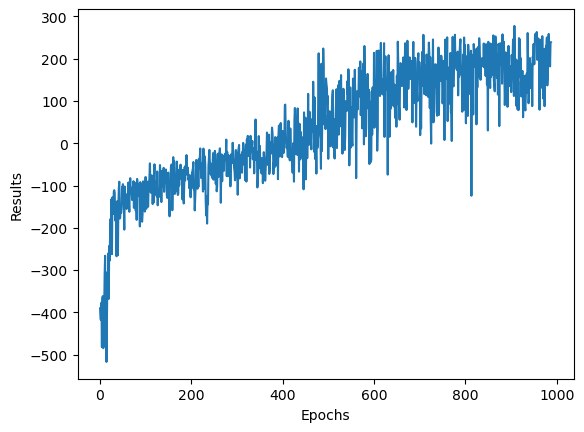

In [13]:
x = range(1,epoch+2)
y = graph_results

plt.plot(x, y)
plt.xlabel('Epochs')
plt.ylabel('Results')
plt.show()